# Compare different similarity methods

- Pocket structure similarity (`kissim`)
- Pocket sequence similarity (KLIFS seq)
- Interaction similarity (KLIFS IFP)
- Compare matrices!

Resources:

- [SciPy: Jaccard distance](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.jaccard.html#scipy.spatial.distance.jaccard)
- [Scikit-Learn: Pairwise distances](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

from opencadd.databases import klifs

In [3]:
HERE = Path(_dh[-1])  # noqa: F821
RESULTS = HERE / "../../results/"
DATA = HERE / "../../data/"

In [4]:
klifs_session = klifs.setup_remote()

## Pocket structure similarity: `kissim`

### Kinase matrix

In [5]:
kissim_matrix = pd.read_csv(RESULTS / "fingerprint_distances_to_kinase_matrix.csv", index_col=0)
kissim_matrix = 1 - (kissim_matrix - kissim_matrix.min().min()) / (
    kissim_matrix.max().max() - kissim_matrix.min().min()
)
kissim_matrix

,AAK1,ABL1,ABL2,ACK,ACTR2,ACTR2B,ADCK3,AKT1,AKT2,ALK,...,ZAK,ZAP70,p110a,p110d,p110g,p38a,p38b,p38d,p38g,p70S6K
AAK1,1.000000,0.781014,0.774964,0.774639,0.761247,0.756589,0.724389,0.790946,0.772703,0.773205,...,0.755657,0.783193,0.687977,0.648551,0.656563,0.795924,0.776974,0.790226,0.779415,0.799548
ABL1,0.781014,1.000000,0.970411,0.874249,0.744005,0.754699,0.686148,0.784996,0.796639,0.893395,...,0.808578,0.845497,0.699027,0.650492,0.664317,0.816532,0.800798,0.796677,0.803806,0.817098
ABL2,0.774964,0.970411,1.000000,0.863916,0.730568,0.743040,0.685955,0.786058,0.794322,0.886949,...,0.795238,0.833460,0.681636,0.647822,0.658012,0.813853,0.800500,0.781018,0.793011,0.800569
ACK,0.774639,0.874249,0.863916,1.000000,0.731755,0.741779,0.679790,0.773574,0.796480,0.857053,...,0.814704,0.858662,0.688701,0.660563,0.660732,0.807339,0.792774,0.785446,0.795842,0.797115
ACTR2,0.761247,0.744005,0.730568,0.731755,1.000000,0.941142,0.678717,0.716377,0.698470,0.733958,...,0.722208,0.717530,0.625792,0.590652,0.594786,0.731091,0.723999,0.727631,0.725973,0.719863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p38a,0.795924,0.816532,0.813853,0.807339,0.731091,0.727933,0.731956,0.791516,0.807082,0.812034,...,0.765164,0.802720,0.707553,0.689612,0.704114,1.000000,0.936852,0.913002,0.904907,0.825261
p38b,0.776974,0.800798,0.800500,0.792774,0.723999,0.715094,0.681705,0.766064,0.789922,0.805151,...,0.768276,0.787109,0.687761,0.652138,0.664122,0.936852,1.000000,0.890716,0.903928,0.812909
p38d,0.790226,0.796677,0.781018,0.785446,0.727631,0.723990,0.688436,0.786178,0.799902,0.791736,...,0.753414,0.809712,0.710097,0.651433,0.661131,0.913002,0.890716,1.000000,0.899054,0.818189
p38g,0.779415,0.803806,0.793011,0.795842,0.725973,0.723229,0.667273,0.784833,0.811065,0.805444,...,0.742450,0.785827,0.707728,0.654594,0.671009,0.904907,0.903928,0.899054,1.000000,0.828024


In [6]:
kissim_matrix.min().min(), kissim_matrix.max().max()

(0.0, 1.0)

### Get kinases and structure KLIFS IDs from `kissim` dataset

#### Kinase names

In [7]:
kinase_names = kissim_matrix.columns.to_list()
print(f"Number of kinase names: {len(kinase_names)}")
print(*kinase_names[:5])

Number of kinase names: 292
AAK1 ABL1 ABL2 ACK ACTR2


#### Kinase KLIFS IDs

In [8]:
kinases = klifs_session.kinases.by_kinase_name(kinase_names)
kinases = kinases[kinases["species.klifs"] == "Human"]
kinase_klifs_ids = kinases["kinase.klifs_id"].to_list()
print(f"Number of kinase KLIFS IDs: {len(kinase_klifs_ids)}")
print(*kinase_klifs_ids[:5])

Processing...:   0%|          | 0/292 [00:00<?, ?it/s]

Number of kinase KLIFS IDs: 293
277 392 393 394 523


#### Structure KLIFS IDs

In [9]:
structures = klifs_session.structures.by_kinase_klifs_id(kinase_klifs_ids)
structure_klifs_ids = structures["structure.klifs_id"].to_list()
print(f"Number of structure KLIFS IDs: {len(structure_klifs_ids)}")
print(*structure_klifs_ids[:5])

Number of structure KLIFS IDs: 11556
2545 10439 2544 2543 10880


## Pocket sequence similarity: KLIFS sequence

### Kinase matrix

In [13]:
def kinase_matrix_by_seq(kinase_klifs_ids):

    print("Fetch kinases...")
    kinases = klifs_session.kinases.by_kinase_klifs_id(kinase_klifs_ids)
    kinases = kinases[kinases["kinase.pocket"].apply(len) == 85]

    print("Calculate kinase matrix...")
    seq_matrix = kinases["kinase.pocket"].apply(list)
    X = np.array(seq_matrix.to_list())
    # Expand
    identity = X[:, None, :] == X[None, :, :]
    # Reduce
    kinase_matrix = identity.sum(axis=-1) / X.shape[1]
    kinase_names = kinases["kinase.klifs_name"].to_list()
    kinase_matrix = pd.DataFrame(kinase_matrix, index=kinase_names, columns=kinase_names)

    return kinase_matrix

In [14]:
seq_matrix = kinase_matrix_by_seq(kinase_klifs_ids)
seq_matrix = (seq_matrix - seq_matrix.min().min()) / (
    seq_matrix.max().max() - seq_matrix.min().min()
)
seq_matrix

Fetch kinases...
Calculate kinase matrix...


,AKT1,AKT2,DMPK1,MRCKb,ROCK1,ROCK2,BARK1,GPRK4,GPRK5,GPRK6,...,BMPR2,TGFbR2,MLKL,p110g,p110d,p110a,PIK3C3,PI4K2A,PI4KB,PI4K2B
AKT1,1.000000,0.864198,0.382716,0.419753,0.358025,0.358025,0.407407,0.432099,0.432099,0.419753,...,0.271605,0.259259,0.197531,0.111111,0.086420,0.098765,0.185185,0.123457,0.098765,0.123457
AKT2,0.864198,1.000000,0.419753,0.456790,0.395062,0.395062,0.419753,0.432099,0.432099,0.432099,...,0.246914,0.259259,0.172840,0.111111,0.086420,0.098765,0.185185,0.098765,0.098765,0.098765
DMPK1,0.382716,0.419753,1.000000,0.876543,0.580247,0.580247,0.370370,0.345679,0.345679,0.358025,...,0.296296,0.308642,0.209877,0.086420,0.098765,0.111111,0.135802,0.111111,0.148148,0.111111
MRCKb,0.419753,0.456790,0.876543,1.000000,0.592593,0.592593,0.407407,0.345679,0.370370,0.358025,...,0.308642,0.283951,0.185185,0.061728,0.074074,0.086420,0.135802,0.123457,0.123457,0.123457
ROCK1,0.358025,0.395062,0.580247,0.592593,1.000000,0.987654,0.382716,0.370370,0.395062,0.382716,...,0.283951,0.271605,0.197531,0.086420,0.086420,0.086420,0.123457,0.111111,0.098765,0.111111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p110a,0.098765,0.098765,0.111111,0.086420,0.086420,0.098765,0.049383,0.037037,0.037037,0.037037,...,0.061728,0.086420,0.086420,0.691358,0.728395,1.000000,0.444444,0.135802,0.395062,0.160494
PIK3C3,0.185185,0.185185,0.135802,0.135802,0.123457,0.135802,0.074074,0.086420,0.086420,0.086420,...,0.111111,0.123457,0.086420,0.456790,0.456790,0.444444,1.000000,0.185185,0.407407,0.185185
PI4K2A,0.123457,0.098765,0.111111,0.123457,0.111111,0.111111,0.148148,0.148148,0.123457,0.135802,...,0.172840,0.111111,0.061728,0.123457,0.135802,0.135802,0.185185,1.000000,0.172840,0.876543
PI4KB,0.098765,0.098765,0.148148,0.123457,0.098765,0.111111,0.123457,0.086420,0.086420,0.086420,...,0.135802,0.123457,0.074074,0.407407,0.370370,0.395062,0.407407,0.172840,1.000000,0.172840


In [15]:
seq_matrix.min().min(), seq_matrix.max().max()

(0.0, 1.0)

## Interaction similarity: KLIFS IFP

### Kinase matrix

In [10]:
def kinase_matrix_by_ifp(structure_klifs_ids, dfg="in", metric="jaccard"):

    print("Fetch IFPs...")
    ifps = klifs_session.interactions.by_structure_klifs_id(structure_klifs_ids)
    ifps.dropna(subset=["interaction.fingerprint"], inplace=True)

    print("Fetch structures...")
    structures = klifs_session.structures.by_structure_klifs_id(structure_klifs_ids)
    structures = structures[structures["structure.dfg"] == dfg]
    structure_klifs_ids = structures["structure.klifs_id"].to_list()

    ifps = ifps.merge(structures, on="structure.klifs_id", how="inner")
    structure_klifs_ids = ifps["structure.klifs_id"].to_list()
    kinase_names = ifps["kinase.klifs_name"].to_list()

    print("Calculate similarity matrix...")
    ifps_matrix = (
        ifps["interaction.fingerprint"]
        .apply(list)
        .apply(lambda x: [True if i == "1" else False for i in x])
        .to_list()
    )
    ifps_matrix = np.array(ifps_matrix)
    distance_matrix = pairwise_distances(ifps_matrix, metric=metric)
    distance_matrix = pd.DataFrame(
        distance_matrix, index=structure_klifs_ids, columns=structure_klifs_ids
    )
    similarity_matrix = 1 - distance_matrix

    print("Calculate kinase matrix...")
    kinase_matrix = similarity_matrix
    kinase_matrix.index = kinase_names
    kinase_matrix.columns = kinase_names
    kinase_matrix = kinase_matrix.stack().groupby(level=[0, 1]).max().unstack(level=1)

    return kinase_matrix

In [11]:
ifp_matrix = kinase_matrix_by_ifp(structure_klifs_ids)
ifp_matrix = (ifp_matrix - ifp_matrix.min().min()) / (
    ifp_matrix.max().max() - ifp_matrix.min().min()
)
ifp_matrix

Fetch IFPs...
Fetch structures...
Calculate similarity matrix...
Calculate kinase matrix...


,AAK1,ABL1,ABL2,ACK,ACTR2,ACTR2B,ADCK3,AKT1,AKT2,ALK,...,ZAK,ZAP70,p110a,p110d,p110g,p38a,p38b,p38d,p38g,p70S6K
AAK1,1.000000,0.715789,0.460000,0.595000,0.705455,0.460000,0.370000,0.656364,0.656364,0.880000,...,0.515862,0.838000,0.640000,0.520000,0.577391,0.595000,0.568000,0.344286,0.537143,0.742857
ABL1,0.715789,1.000000,0.953043,0.730000,0.740800,0.460000,0.460000,0.640000,0.543077,0.775000,...,0.512258,0.784000,0.524800,0.442581,0.481600,0.754545,0.537143,0.426250,0.438400,0.691429
ABL2,0.460000,0.953043,1.000000,0.626154,0.543077,0.295652,0.180690,0.460000,0.428235,0.640000,...,0.476364,0.460000,0.382857,0.292414,0.395200,0.543077,0.407742,0.325000,0.252308,0.382857
ACK,0.595000,0.730000,0.626154,1.000000,0.715789,0.431579,0.488421,0.618824,0.568000,0.794286,...,0.532000,0.730000,0.421429,0.400000,0.460000,0.775000,0.553103,0.480000,0.555294,0.640000
ACTR2,0.705455,0.740800,0.543077,0.715789,1.000000,0.488421,0.418462,0.611200,0.553103,0.765217,...,0.443636,0.765217,0.550000,0.441379,0.568000,0.614286,0.478621,0.329655,0.415000,0.765217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p38a,0.595000,0.754545,0.543077,0.775000,0.614286,0.491765,0.352000,0.515862,0.485714,0.656364,...,0.640000,0.640000,0.488421,0.436522,0.509091,1.000000,0.870400,0.740800,0.410909,0.575714
p38b,0.568000,0.537143,0.407742,0.553103,0.478621,0.308800,0.233548,0.441379,0.478621,0.568000,...,0.595000,0.560000,0.344286,0.382857,0.388000,0.870400,1.000000,0.312727,0.320000,0.442581
p38d,0.344286,0.426250,0.325000,0.480000,0.329655,0.222400,0.156250,0.352000,0.344286,0.460000,...,0.424000,0.303226,0.360000,0.290286,0.388000,0.740800,0.312727,1.000000,0.228571,0.392500
p38g,0.537143,0.438400,0.252308,0.555294,0.415000,0.340000,0.361818,0.760000,0.715789,0.488421,...,0.352000,0.580000,0.382857,0.361818,0.410909,0.410909,0.320000,0.228571,1.000000,0.537143


In [12]:
ifp_matrix.min().min(), ifp_matrix.max().max()

(0.0, 1.0)

## Compare matrices

### Shared kinases

In [16]:
kissim_matrix.shape, seq_matrix.shape, ifp_matrix.shape

((292, 292), (292, 292), (251, 251))

In [17]:
kinase_names = set(kissim_matrix.columns.to_list()) & set(seq_matrix.columns.to_list())
kinase_names = kinase_names & set(ifp_matrix.columns.to_list())
kinase_names = sorted(kinase_names)
print(f"Number of shared kinases: {len(kinase_names)}")

Number of shared kinases: 251


In [18]:
kissim_matrix = kissim_matrix.loc[kinase_names, kinase_names]
seq_matrix = seq_matrix.loc[kinase_names, kinase_names]
ifp_matrix = ifp_matrix.loc[kinase_names, kinase_names]

### Scatter plot

In [19]:
kissim_pairs = kissim_matrix.to_numpy()[np.tril_indices(kissim_matrix.to_numpy().shape[0], -1)]
seq_pairs = seq_matrix.to_numpy()[np.tril_indices(seq_matrix.to_numpy().shape[0], -1)]
ifp_pairs = ifp_matrix.to_numpy()[np.tril_indices(ifp_matrix.to_numpy().shape[0], -1)]

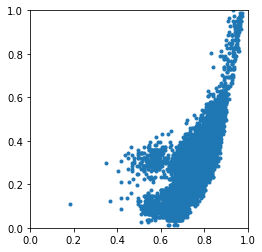

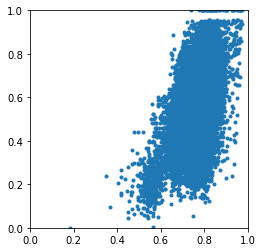

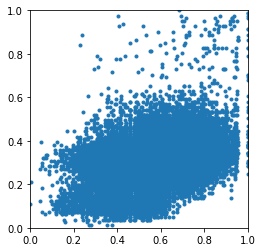

In [20]:
for i, pair in enumerate(
    [[kissim_pairs, seq_pairs], [kissim_pairs, ifp_pairs], [ifp_pairs, seq_pairs]]
):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(pair[0], pair[1], ".")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    ax.set_aspect("equal", adjustable="box")